In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, lax, jit, vmap

import numpyro
from numpyro.contrib.nested_sampling import NestedSampler
import numpyro.distributions as dist
from numpyro.handlers import block, condition
from numpyro.infer import MCMC, NUTS, init_to_value, log_likelihood

numpyro.enable_x64()

In [2]:
# Load data
lc = np.loadtxt("lc.txt")
interp = np.loadtxt("interp.txt")
t, F, Ferr = lc
points, zeta_e, zeta_n, zeta_e_dot, zeta_n_dot = interp

In [3]:
def model(t, F, Ferr):
    DeltaF = numpyro.sample("DeltaF", dist.LogNormal(4.0, 4.0))
    Fbase = numpyro.sample("Fbase", dist.LogNormal(2.0, 4.0))
    t0 = numpyro.sample("t0", dist.Normal(3630.0, 50.0))
    tE = numpyro.sample("tE", dist.LogNormal(3.0, 6.0))
    u0 = numpyro.sample("u0", dist.Normal(0.0, 1.0))
    piEE = numpyro.sample("piEE", dist.Normal(0.0, 0.5))
    piEN = numpyro.sample("piEN", dist.Normal(0.0, 0.5))

    # Compute trajectory
    zeta_e_t = jnp.interp(t, points, zeta_e)
    zeta_n_t = jnp.interp(t, points, zeta_n)
    zeta_e_t0 = jnp.interp(t0, points, zeta_e)
    zeta_n_t0 = jnp.interp(t0, points, zeta_n)
    zeta_e_dot_t0 = jnp.interp(t0, points, zeta_e_dot)
    zeta_n_dot_t0 = jnp.interp(t0, points, zeta_n_dot)

    delta_zeta_e = zeta_e_t - zeta_e_t0 - (t - t0) * zeta_e_dot_t0
    delta_zeta_n = zeta_n_t - zeta_n_t0 - (t - t0) * zeta_n_dot_t0

    u_per = u0 + piEN * delta_zeta_e - piEE * delta_zeta_n
    u_par = (t - t0) / tE + piEE * delta_zeta_e + piEN * delta_zeta_n
    u = jnp.sqrt(u_per ** 2 + u_par ** 2)

    # Magnification
    A_u = (u ** 2 + 2) / (u * jnp.sqrt(u ** 2 + 4))
    A_u0 = (u0 ** 2 + 2) / (jnp.abs(u0) * jnp.sqrt(u0 ** 2 + 4))
    A = (A_u - 1) / (A_u0 - 1)
    F_pred = DeltaF * A + Fbase

    ln_c = numpyro.sample("ln_c", dist.Exponential(1 / 2.0))
    numpyro.sample("data_dist", dist.Normal(F_pred, jnp.exp(ln_c) * Ferr), obs=F)

### NUTS

sample: 100%|██████████| 2000/2000 [00:22<00:00, 87.15it/s, 63 steps of size 5.50e-02. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    DeltaF    263.89      0.90    263.89    262.42    265.36    855.99      1.00
     Fbase    187.23      0.12    187.23    187.04    187.41    457.47      1.00
      ln_c      0.20      0.03      0.20      0.16      0.25    909.21      1.00
      piEE      0.12      0.01      0.12      0.10      0.14    372.90      1.01
      piEN      0.30      0.04      0.30      0.23      0.37    565.78      1.00
        t0   3629.78      0.19   3629.79   3629.43   3630.06    574.49      1.00
        tE     93.18      2.70     93.23     88.51     97.35    339.10      1.00
        u0      0.49      0.02      0.49      0.45      0.53    315.14      1.01

Number of divergences: 0


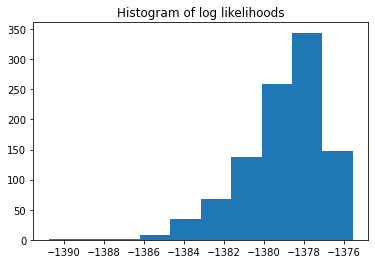

In [4]:
mcmc = MCMC(NUTS(model, init_strategy=init_to_value(values={"t0": 3630.})),
            num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0), t, F, Ferr)
mcmc.print_summary()

ll = log_likelihood(model, mcmc.get_samples(), t, F, Ferr)['data_dist'].sum(-1)
plt.hist(ll)
plt.title("Histogram of log likelihoods");

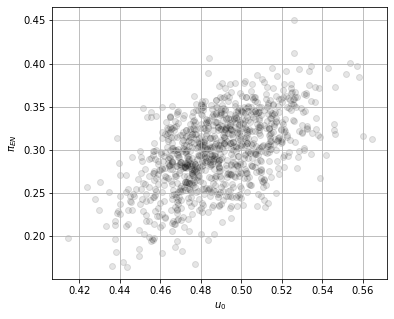

In [5]:
samples = mcmc.get_samples()
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(samples["u0"], samples["piEN"], color="black", alpha=0.1)
# ax.set(xlim=(-0.8, 0.8), ylim=(-0.8, 0.8))
ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")
ax.grid()

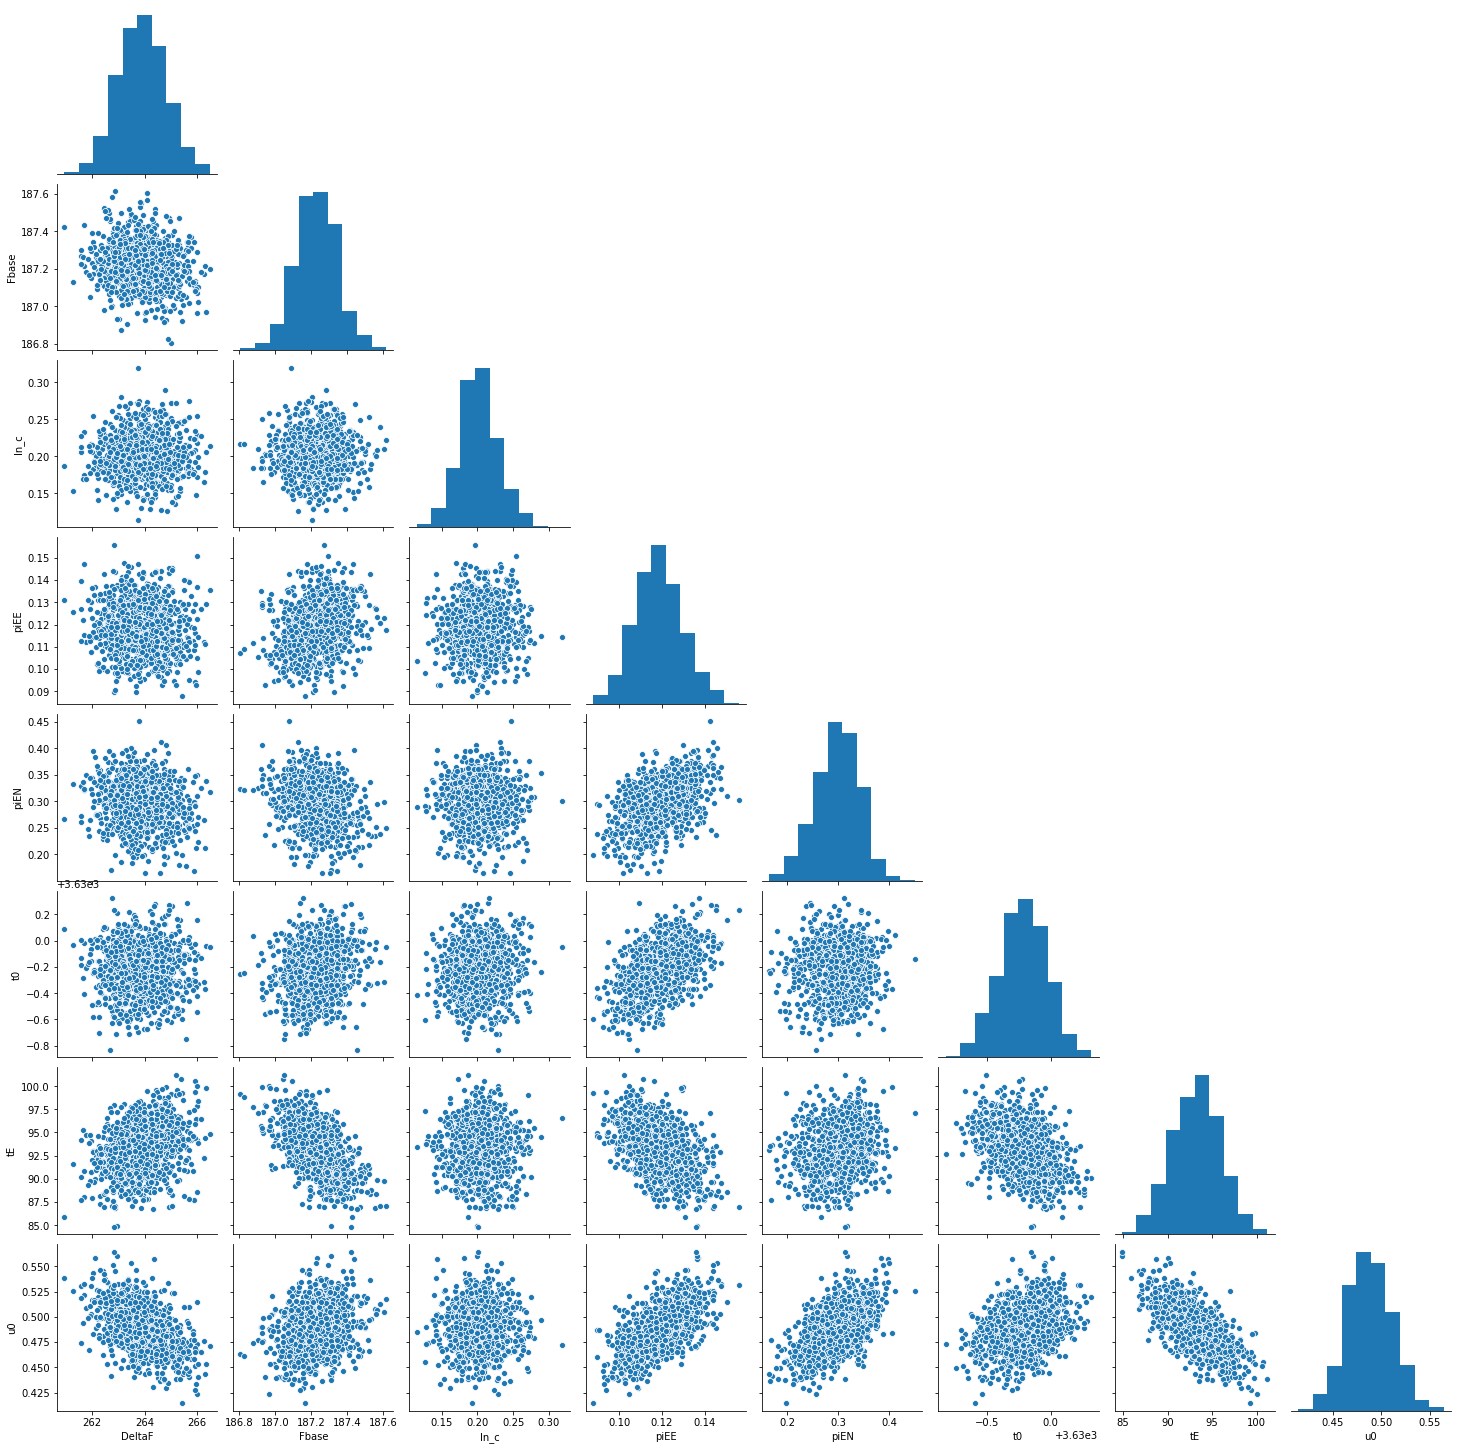

In [6]:
df = pd.DataFrame.from_dict(samples).astype(float)
sns.pairplot(df, corner=True);

### Nested Sampling

Number of weighted samples: 108560
Effective sample size: 15028.9
Maximum log likelihood: -1374.3002486775738


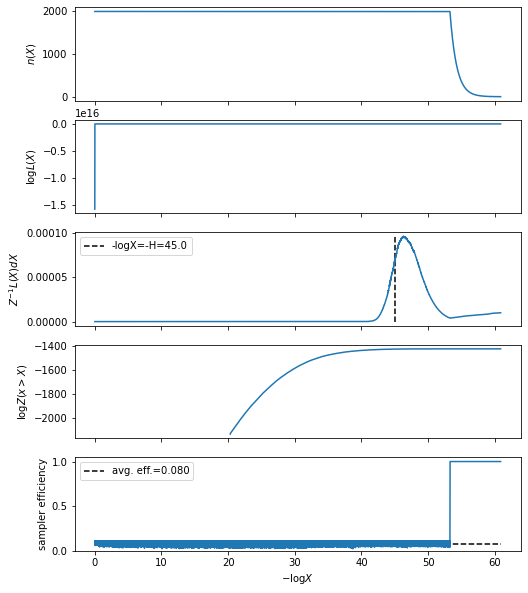

In [7]:
ns = NestedSampler(model, num_live_points=2000, max_samples=2e5,
                   sampler_kwargs=dict(depth=5, num_slices=3))
ns.run(random.PRNGKey(0), t, F, Ferr)
num_samples = ns._log_weights.shape[0]
print("Maximum log likelihood:", max(ns._results.log_L_samples[:num_samples]))
ns.diagnostics(cornerplot=False)  # cornerplot is slow

We can see that log likelihood of `ns` is much smaller than `mcmc`. Let's resampling 100000 samples

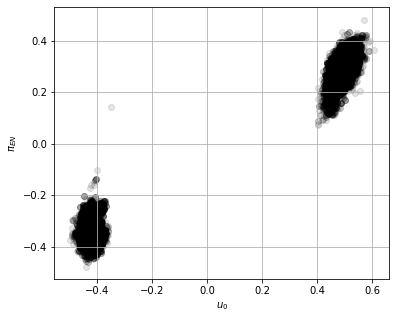

In [8]:
samples = ns.get_samples(random.PRNGKey(1), 100000)
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(samples["u0"], samples["piEN"], color="black", alpha=0.1)
ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")
ax.grid()

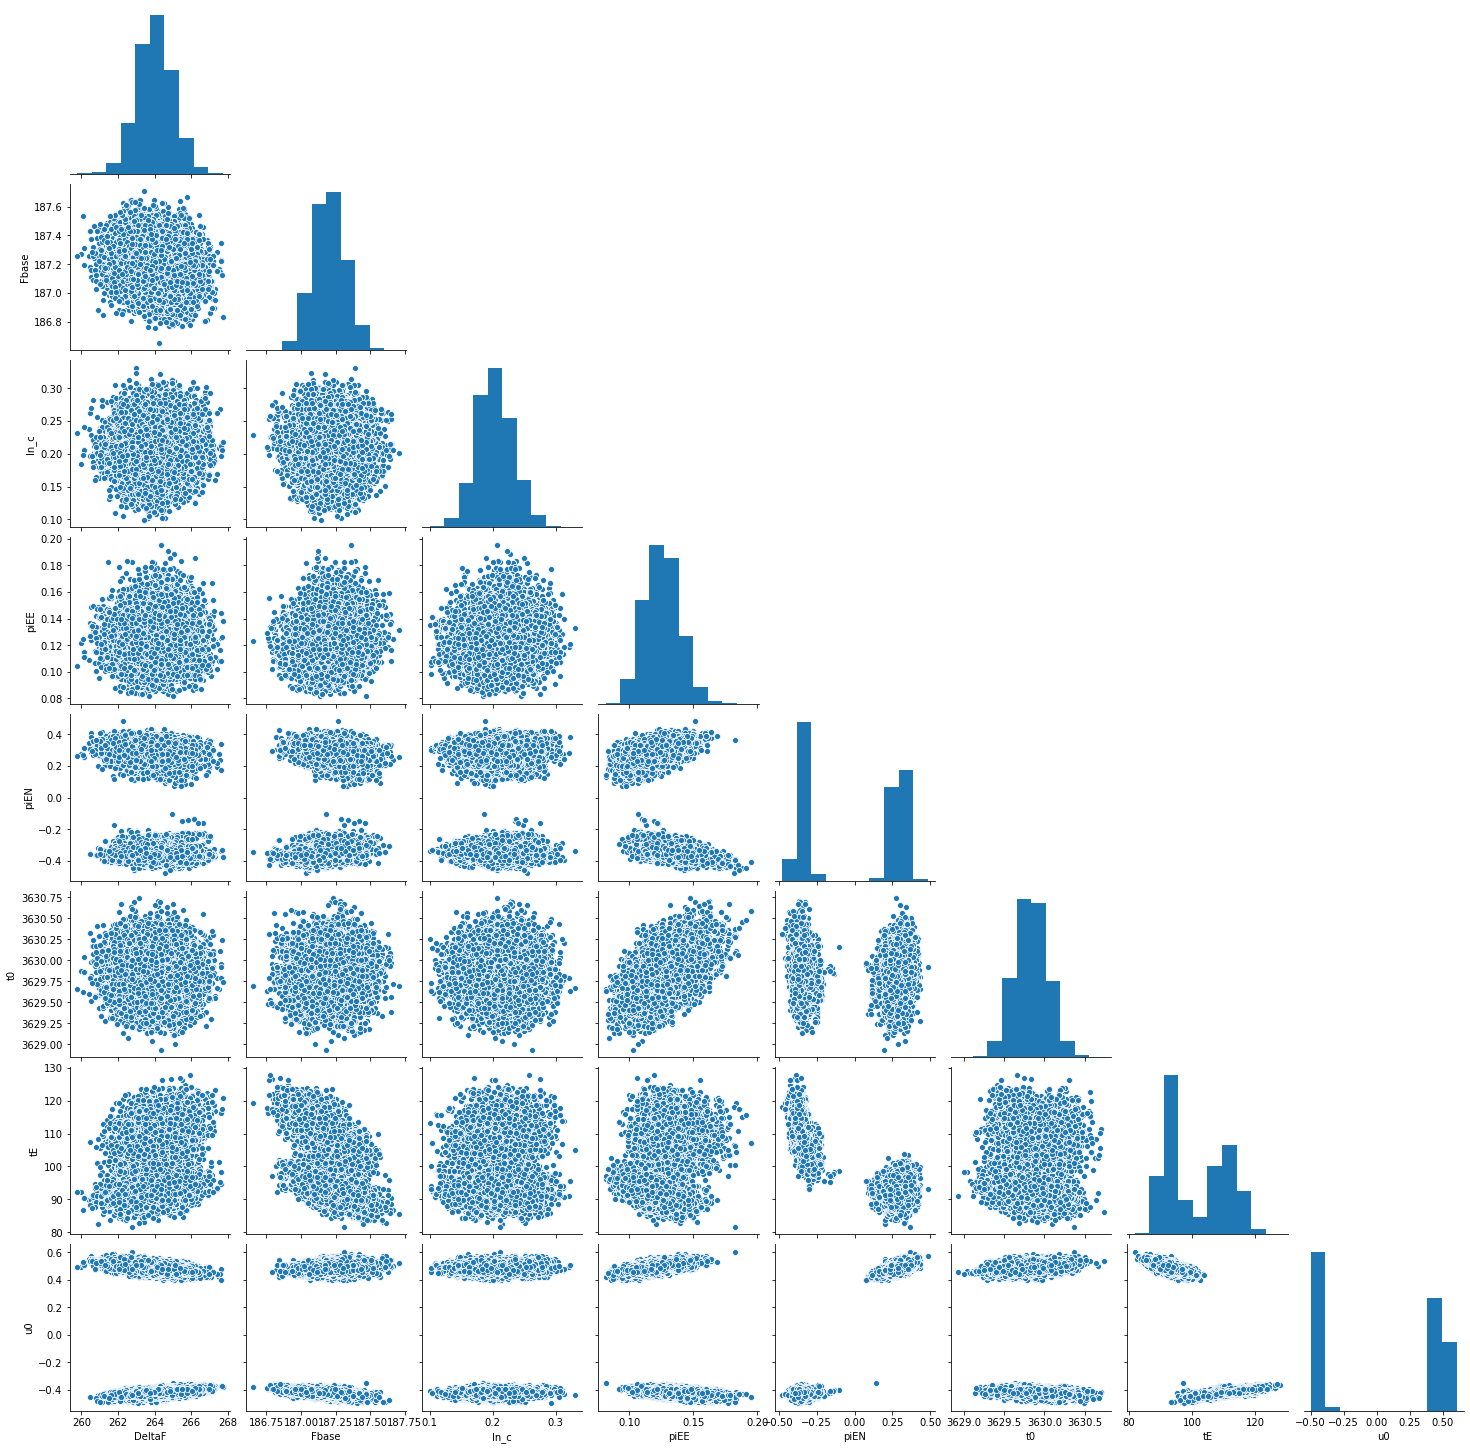

In [9]:
df = pd.DataFrame.from_dict(samples).astype(float)
sns.pairplot(df, corner=True);